In [67]:
# import necessary classes
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [103]:
# initialize some constants which will be used as parameters later
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20

In [69]:
# load the dataset using the tf api
# details are in the link -  https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory
dataset_potato = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [70]:
import os

directory_path = "PlantVillage/"

names = os.listdir(directory_path)
print(names)

['Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight']


In [71]:
# folders which are present in the directory will be shown here as class names
class_names_potato = dataset_potato.class_names
class_names_potato

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [72]:
# shows 68 as we have i set having 32 images
len(class_names_potato)

3

In [73]:
for image_batch, labels_batch in dataset_potato.take(1):
    # says there are 32 images with size 256 by 256 and with three channels for RGB color
    print(image_batch.shape)
    # convering into m=numpy array as we get tf element when we get the batch
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


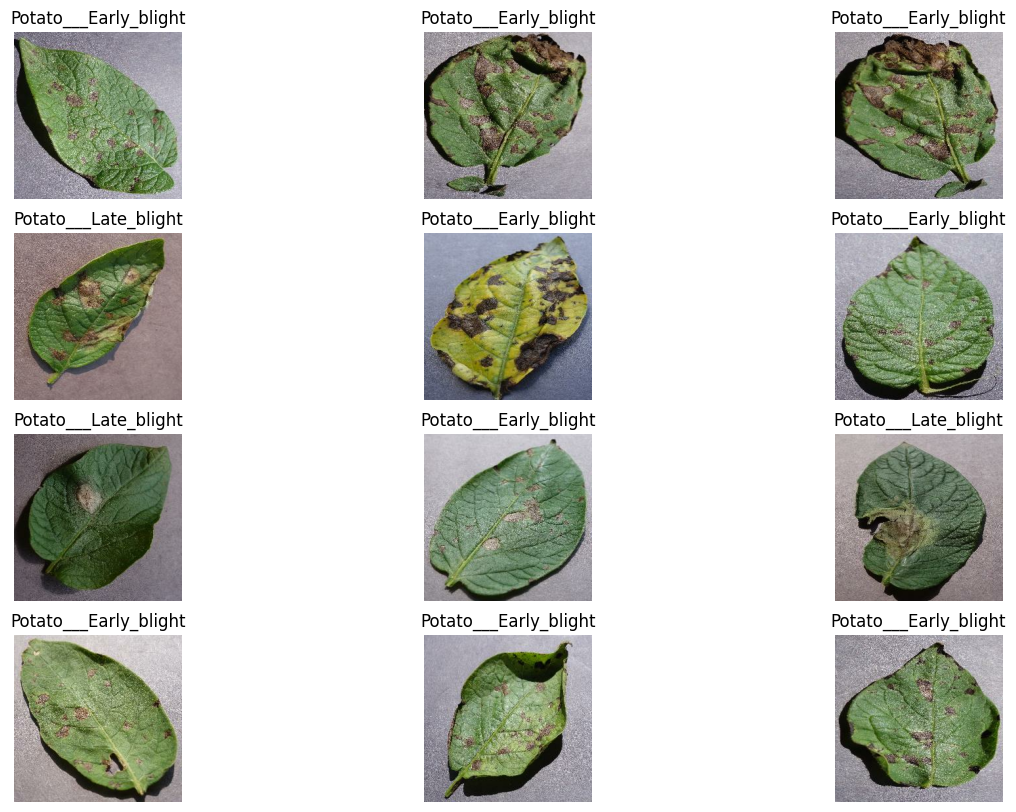

In [74]:
# figsize is done so that images in the sub plot are displayed without overlap
plt.figure(figsize=(15, 10))
# plot the first batch, that too only 12 images and not 32 as in the batch
for image_batch, labels_batch in dataset_potato.take(1):
    for i in range(12):
        # plot the images using subplots
        # will plot 12 images 
        ax = plt.subplot(4, 3, i + 1)
        # converting to numpy as the result object is a tf object and convert into integer as we get in values in float
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        # display the title - we are interating over the class name got earlier so that we display the names 
        # instead of numbers
        plt.title(class_names_potato[labels_batch[i]])
        # off the axis
        plt.axis("off")

now let us do train test split - 
80% as training data
10% as validation data
10% as test data

In [75]:
# since we dont have train test split in tensor flow, lets use the methonds given in tf to achieve this

In [84]:
# take 80% of the data as training set
# for that we need to know the number of datasets to take from the data that we have downloaded.
# in our case it is 54 datasets out of length of the downloaded dataset - 63
c = 0.8
# int(len(dataset_potato.numpy()) * potato_train_ds)

# Assuming dataset_potato is your TensorFlow dataset object
dataset_length = tf.data.experimental.cardinality(dataset_potato).numpy()
print(dataset_length)
print(int(dataset_length * c))

68
54


In [85]:
potato_train_ds = dataset_potato.take(54)
len(potato_train_ds)

54

In [86]:
# skip the first 400 sets and make the remaining into test_val_ds
potato_test_val_ds = dataset_potato.skip(54)
len(potato_test_val_ds)

14

In [87]:
# the above gives the remaining 20% of the data
# but we need 10% of this data as validation set
# let us take 50% of the remaining data as validation data
# the remaining as test data
potato_val_count_perc = 0.5
potato_val_count = len(potato_test_val_ds) * potato_val_count_perc
int(potato_val_count)


7

In [88]:
potato_val_ds = potato_test_val_ds.take(int(potato_val_count))
len(potato_val_ds)

7

In [89]:
potato_test_ds = potato_test_val_ds.skip(7)
len(potato_test_ds)

7

In [90]:
def get_train_val_test_dataset(ds, train_count = 0.8, val_count = 0.1, test_count = 0.1, shuffle = True, shuffle_size = 10000):
    # train dataset will depend on the length of the dataset and the train_count
    # assume 50% of the remaining data will go for validation and another 50% will for test set
    
    potato_dataset_size = len(ds)
    
    if(shuffle):
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    potato_train_size = int(train_count * potato_dataset_size)
    potato_val_size = int(val_count * potato_dataset_size)
    potato_test_size = int(test_count * potato_dataset_size)
    
    print(potato_train_size, potato_val_size, potato_test_size)
    
    potato_train_ds = ds.take(potato_train_size)
    #print(train_ds)
    
    potato_val_ds = ds.skip(len(potato_train_ds)).take(potato_val_size)
    
    potato_test_ds = ds.skip(len(potato_train_ds)).skip(len(potato_val_ds))
    
    return potato_train_ds, potato_val_ds, potato_test_ds




In [91]:
potato_train_ds, potato_val_ds, potato_test_ds = get_train_val_test_dataset(dataset_potato)

54 6 6


In [92]:
# cache, shuffle and prefetch the data
potato_train_ds = potato_train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
potato_val_ds = potato_val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
potato_test_ds = potato_test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [93]:
print(len(potato_train_ds), len(potato_val_ds), len(potato_test_ds))

54 6 8


In [94]:
# data preprocessing
# improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256)
# resizing will be useful when we are done with the training and start using the model for predictions
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [95]:
# data_augmentation - increases the the accuracy of our model by augmenting the data
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [96]:
# Use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, 
# normalization and Data Augmentation
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

potato_model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

potato_model.build(input_shape=input_shape)

In [97]:
print("Model input shape:", potato_model.input_shape)



Model input shape: (32, 256, 256, 3)


In [98]:
# retrieves a single sample input and its corresponding target label from the potato_train_ds dataset, 
# allowing you to inspect and work with individual data points in the dataset

sample_input, sample_target = next(iter(potato_train_ds))  # Assuming 'train_ds' is your training dataset
print("Dataset input shape:", sample_input.shape)


Dataset input shape: (32, 256, 256, 3)


In [99]:
if potato_model.input_shape[1:] == sample_input.shape[1:]:
    print("Model input shape matches dataset input shape.")
else:
    print("Model input shape does not match dataset input shape.")


Model input shape matches dataset input shape.


In [100]:
potato_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [101]:
# compile the model
potato_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [104]:
# running 13 epochs took a long time and the execution stopped after 13 epochs so cancelled
# have run only 10 epochs - the accuracy will improve further if it is run for more epochs
# looks loke the power of the machine that I have is insufficient to run this model
# I need to run this in cloud, to get the results - the Kernel died after running the first epoch 
# This has happened multiple times
history = potato_model.fit(
    potato_train_ds,
    batch_size=BATCH_SIZE,
    validation_data=potato_val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/20
54/54 [==============================] - 46s 841ms/step - loss: 0.1686 - accuracy: 0.9323 - val_loss: 0.1604 - val_accuracy: 0.9531
Epoch 2/20
54/54 [==============================] - 38s 706ms/step - loss: 0.1520 - accuracy: 0.9456 - val_loss: 0.1933 - val_accuracy: 0.9062
Epoch 3/20
54/54 [==============================] - 39s 720ms/step - loss: 0.1192 - accuracy: 0.9525 - val_loss: 0.1230 - val_accuracy: 0.9479
Epoch 4/20
54/54 [==============================] - 38s 711ms/step - loss: 0.1257 - accuracy: 0.9514 - val_loss: 0.3464 - val_accuracy: 0.8594
Epoch 5/20
54/54 [==============================] - 38s 706ms/step - loss: 0.1290 - accuracy: 0.9618 - val_loss: 0.0992 - val_accuracy: 0.9531
Epoch 6/20
54/54 [==============================] - 38s 698ms/step - loss: 0.1150 - accuracy: 0.9543 - val_loss: 0.1021 - val_accuracy: 0.9583
Epoch 7/20
54/54 [==============================] - 40s 734ms/step - loss: 0.1026 - accuracy: 0.9543 - val_loss: 0.1573 - val_accuracy: 0.9583

In [105]:
scores = potato_model.evaluate(potato_test_ds)

8/8 [==============================] - 10s 206ms/step - loss: 0.0805 - accuracy: 0.9844


In [106]:
scores

[0.08049123734235764, 0.984375]

In [107]:
# Plotting the Accuracy and Loss Curves
history

In [108]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 54}

In [109]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [110]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

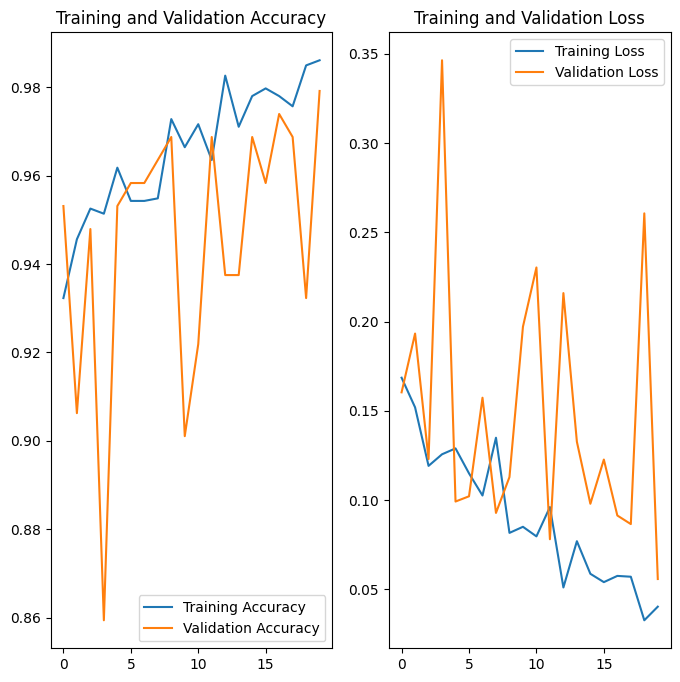

In [111]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 323ms/step
predicted label: Potato___Late_blight


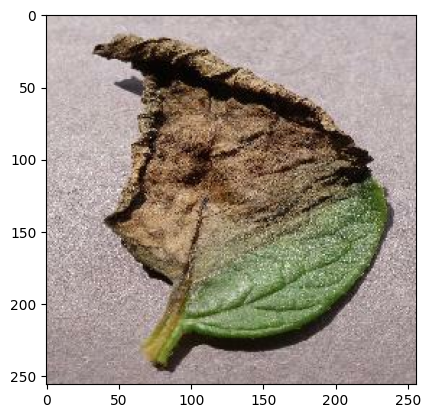

In [117]:
# predict on some sample image
import numpy as np
for images_batch, labels_batch in potato_test_ds.take(1):
    
    first_image = images_batch[31].numpy().astype('uint8')
    first_label = labels_batch[31].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names_potato[first_label])
    
    batch_prediction = potato_model.predict(images_batch)
    print("predicted label:",class_names_potato[np.argmax(batch_prediction[0])])

In [118]:
# function to give predicted_class, confidence based in model, img

def predict(potato_model, img):
    #img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    # converts this into an array - it is a tf function
    # function is used to convert images into a format that can be easily processed 
    # by deep learning models implemented using TensorFlow
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    # below adds an array along the dimension '0'
    #  adding a new dimension along axis 0 allows you to treat single examples as batches of size 1, 
    # providing consistency and compatibility with models and operations that expect batched input data
    img_array = tf.expand_dims(img_array, 0)
    # does predictions on the array as processed above
    predictions = potato_model.predict(img_array)
    # predicts the class of the image based on class_names list.
    predicted_class = class_names_potato[np.argmax(predictions[0])]
    # calculates the confidence of the above predictions of the first sample
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

1/1 [==============================] - 0s 63ms/step


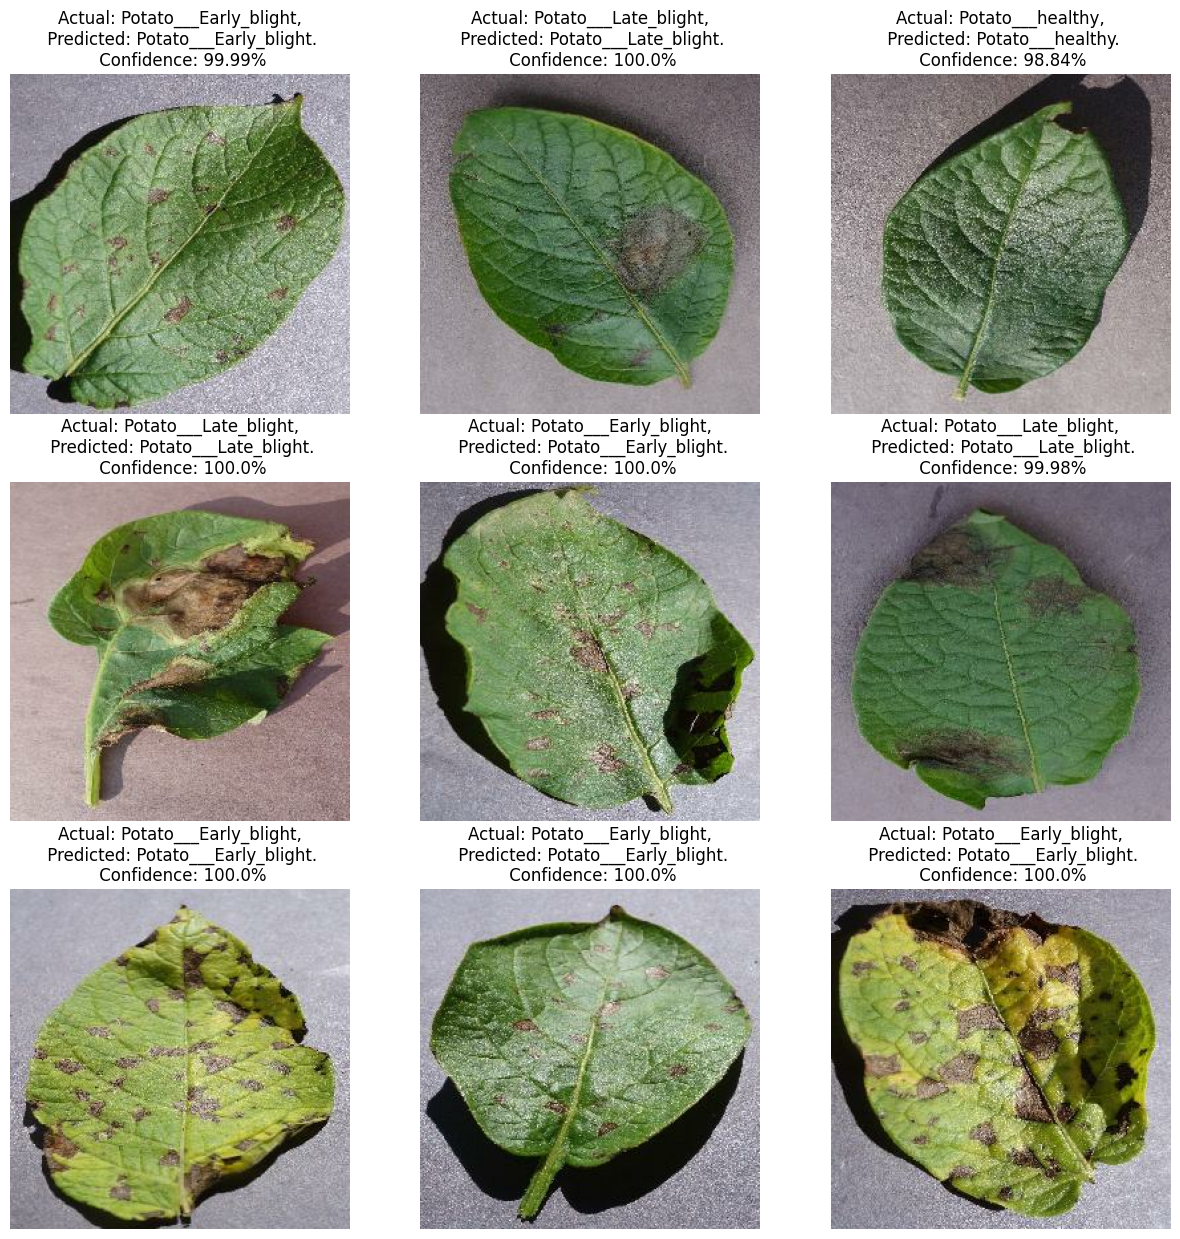

In [120]:
# plot the 9 images in the first batch (as an example)
plt.figure(figsize=(15, 15))

for images, labels in potato_test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(potato_model, images[i].numpy())
        actual_class = class_names_potato[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        # remove the axis
        plt.axis("off")

In [121]:
# returns the folders present in any directory - in this case 'models'
# the model version depends on the number of folders present
import os
model_version=max([int(k) for k in os.listdir("models") + [0]])+1
print(os.listdir("models"))
print('model_version    ',model_version)
#model.save(f"/models/{model_version}")

['1', '2']
model_version     3


In [123]:
# We append the model to the list of models as a new version
potato_model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/3\assets


INFO:tensorflow:Assets written to: models/3\assets
